In [4]:
import torch
import torch.nn as nn #related to neural networks
import torch.optim as optim #optimizer
from torch.utils.data import DataLoader, Dataset
import torchvision
import os
import pandas as pd
from torchvision.io import read_image
from torchvision import transforms, models
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
import sys
import timm
import tqdm
from PIL import Image
import json

import matplotlib.patches as patches
import cv2


In [2]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
if torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

mps


Selected image: images/train/Screenshot 2024-10-10 185220.png
Annotations for selected image:
[{'class_id': 35, 'polygon': [(359.00012499999997, 292.00005899999996), (423.99969500000003, 292.00005899999996), (423.99969500000003, 356.999985), (359.00012499999997, 356.999985)]}]


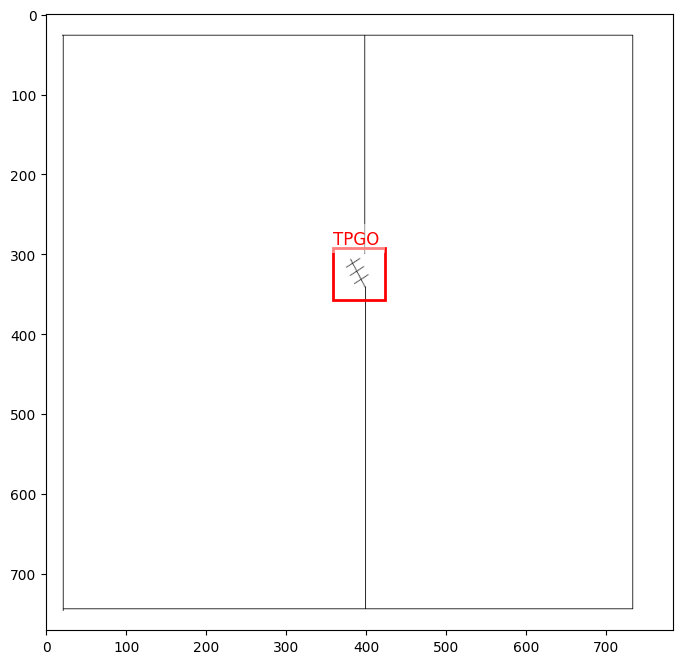

In [7]:
from glob import glob
import yaml

with open("data.yaml", "r") as f:
    data = yaml.safe_load(f)
    
# Define directories
image_dir = "images/train"

label_dir = "labels/train"

# Get list of image files
image_files = glob(os.path.join(image_dir, "*.png"))
image_files.sort()

# Load categories (if available)
categories = [name for name in data["names"]]

# Select the 150th image (modify index as needed)
x = 14
selected_image_path = image_files[x]
print(f"Selected image: {selected_image_path}")

# Load the image
image = cv2.imread(selected_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_height, img_width, _ = image.shape

# Load corresponding annotations
label_filename = os.path.splitext(os.path.basename(selected_image_path))[0] + ".txt"
label_path = os.path.join(label_dir, label_filename)

annotations = []
if os.path.exists(label_path):
    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 1 or (len(parts) - 1) % 2 != 0:
                continue  # Skip invalid lines (odd number of coordinates)

            class_id = int(parts[0])
            polygon_norm = list(map(float, parts[1:]))  # Get all normalized coordinates
            
            # Convert normalized coordinates to absolute
            polygon_abs = [
                (x * img_width, y * img_height) 
                for x, y in zip(polygon_norm[::2], polygon_norm[1::2])
            ]
            
            annotations.append({
                'class_id': class_id,
                'polygon': polygon_abs
            })

print("Annotations for selected image:")
print(annotations)

# Plot the image with polygons
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

for ann in annotations:
    polygon = ann['polygon']
    class_id = ann['class_id']
    label = categories[class_id] if categories else str(class_id)
    
    # Draw polygon
    poly_patch = patches.Polygon(
        polygon,
        closed=True,
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(poly_patch)
    
    # Add label at the top-left corner of the polygon's bounding box
    polygon_np = np.array(polygon)
    x_min, y_min = polygon_np.min(axis=0)
    plt.text(
        x_min, y_min - 5,
        label,
        color='red',
        fontsize=12,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )

plt.show()

# Create Circuit Diagram Dataset

In [5]:
class CircuitDiagramDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, img_size=224):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_size = img_size
        
        # Get list of image files
        self.image_files = [f for f in os.listdir(image_dir) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        original_width, original_height = image.size
        
        # Load corresponding YOLO annotations
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(self.label_dir, label_name)
        
        boxes = []
        labels = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) < 9:  # At least 1 class + 4 points (8 coordinates)
                        continue
                    
                    # Parse YOLO polygon format
                    class_id = int(parts[0])
                    polygon_norm = list(map(float, parts[1:]))
                    
                    # Convert normalized polygon to absolute coordinates
                    polygon_abs = [
                        (x * original_width, y * original_height) 
                        for x, y in zip(polygon_norm[::2], polygon_norm[1::2])
                    ]
                    
                    # Convert polygon to bounding box
                    polygon_np = np.array(polygon_abs)
                    x_min, y_min = polygon_np.min(axis=0)
                    x_max, y_max = polygon_np.max(axis=0)
                    
                    # Convert to [x_min, y_min, x_max, y_max] format
                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(class_id)

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            
        # Scale boxes to target image size
        scale_x = self.img_size / original_width
        scale_y = self.img_size / original_height
        
        boxes = torch.tensor(boxes, dtype=torch.float32)
        if boxes.nelement() != 0:  # Check if boxes is not empty
            boxes[:, 0::2] *= scale_x  # x coordinates
            boxes[:, 1::2] *= scale_y  # y coordinates

        labels = torch.tensor(labels, dtype=torch.int64)
        
        # Create target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx])
        }
        
        return image, target

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = CircuitDiagramDataset(
    image_dir="images/train",
    label_dir="images/labels",
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Defining Model

In [9]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes=40):
    """
    Create a Faster R-CNN model with a ResNet-50-FPN backbone
    Args:
        num_classes (int): Number of object classes (excluding background)
    """
    # 1. Load pre-trained base model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
        weights='DEFAULT'  # Uses pre-trained weights
    )
    
    # 2. Modify the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Important: num_classes + 1 (for background class)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes + 1)
    
    return model

In [7]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])

# Training

In [ ]:


# Initialize dataset and dataloaders
train_dataset = CircuitDiagramDataset("images/train", "labels/train", transform=transform)
val_dataset = CircuitDiagramDataset("images/val", "labels/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Initialize model
num_classes = 40  # Adjust based on dataset
model = get_model(num_classes)
device = "mps"
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=1e-4, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Training loop
def train_model(model, train_loader, val_loader, device, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for images, targets in train_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for images, targets in val_loader:
                images = list(img.to(device) for img in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                loss_dict = model(images, targets)
                loss = sum(loss for loss in loss_dict.values())
                val_loss += loss.item()
        
        lr_scheduler.step()
        print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    print("Training Complete")

train_model(model, train_loader, val_loader, device, num_epochs=10)


In [ ]:
import torch
from ultralytics import YOLO

torch.backends.cudnn.benchmark = True  # Auto-tune CUDA performance

model = YOLO("yolov8n.pt")  # Use a well-optimized YOLO model

results = model.train(
    data="/home/enerinn/cs-25-338-identifying-and-locating-electronic-components/Model/data.yaml",
    epochs=20,
    batch=16,  # Adjust based on VRAM
    device="cuda",
    workers=4,
    amp=True,  # Mixed precision for Tensor Core speedup
    imgsz=640  # Smaller image size speeds up training
)


metrics = model.val()


New https://pypi.org/project/ultralytics/8.3.83 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.68 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/enerinn/cs-25-338-identifying-and-locating-electronic-components/Model/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=train46, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=F

train: Scanning /home/enerinn/cs-25-338-identifying-and-locating-electronic-components/Model/labels/train.cache... 3162 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3162/3162 [00:00<?, ?it/s]
val: Scanning /home/enerinn/cs-25-338-identifying-and-locating-electronic-components/Model/labels/val.cache... 1054 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1054/1054 [00:00<?, ?it/s]


Plotting labels to /home/enerinn/cs-25-338-identifying-and-locating-electronic-components/runs/detect/train46/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000196, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /home/enerinn/cs-25-338-identifying-and-locating-electronic-components/runs/detect/train46
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.436G      1.782      5.579      1.306         17        640: 100%|██████████| 198/198 [00:36<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.28it/s]

                   all       1054       1055      0.487      0.216      0.154      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.26G      1.531      4.043      1.185         13        640: 100%|██████████| 198/198 [00:28<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.74it/s]

                   all       1054       1055      0.504      0.475      0.446       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.25G      1.479      3.355      1.168         17        640: 100%|██████████| 198/198 [00:28<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.02it/s]


                   all       1054       1055      0.476      0.666      0.647      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.25G      1.431        2.8      1.151         12        640: 100%|██████████| 198/198 [00:27<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.71it/s]


                   all       1054       1055      0.717      0.771      0.811       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.26G      1.387      2.395       1.13         14        640: 100%|██████████| 198/198 [00:27<00:00,  7.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  5.11it/s]


                   all       1054       1055      0.792      0.844      0.883       0.58

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.25G      1.389      2.131      1.122         19        640: 100%|██████████| 198/198 [00:27<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.78it/s]

                   all       1054       1055      0.879      0.885      0.947      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.26G      1.349      1.912      1.113         12        640: 100%|██████████| 198/198 [00:29<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.58it/s]

                   all       1054       1055      0.886      0.864      0.944      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.25G      1.337      1.789      1.104         22        640: 100%|██████████| 198/198 [00:29<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.72it/s]


                   all       1054       1055      0.908      0.939      0.968      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.26G      1.315      1.643      1.101         18        640: 100%|██████████| 198/198 [00:29<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.67it/s]

                   all       1054       1055      0.941      0.956       0.98      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.25G       1.31      1.559        1.1         18        640: 100%|██████████| 198/198 [00:29<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.46it/s]

                   all       1054       1055      0.931       0.96      0.982      0.665


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.26G      1.219      1.422      1.094         10        640: 100%|██████████| 198/198 [00:29<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.50it/s]

                   all       1054       1055      0.937      0.952      0.976      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.25G      1.204      1.318      1.089         10        640: 100%|██████████| 198/198 [00:29<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.40it/s]

                   all       1054       1055      0.945      0.965      0.981      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.26G      1.191      1.235      1.082         10        640: 100%|██████████| 198/198 [00:30<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  4.07it/s]


                   all       1054       1055      0.957      0.976      0.987      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.25G      1.187      1.188      1.076         10        640: 100%|██████████| 198/198 [00:31<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.60it/s]

                   all       1054       1055      0.953      0.964      0.979      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.26G      1.188      1.145      1.073         10        640: 100%|██████████| 198/198 [00:28<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.75it/s]


                   all       1054       1055      0.968      0.971      0.988      0.676

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.25G      1.149      1.094      1.064         10        640: 100%|██████████| 198/198 [00:28<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.75it/s]


                   all       1054       1055      0.969       0.97      0.985      0.674

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.26G      1.157       1.08      1.061         10        640: 100%|██████████| 198/198 [00:28<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.73it/s]


                   all       1054       1055      0.957      0.985      0.987      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.25G      1.151      1.043      1.063         10        640: 100%|██████████| 198/198 [00:29<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.75it/s]


                   all       1054       1055      0.959      0.981      0.986      0.683

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.26G      1.128      1.025      1.052         10        640: 100%|██████████| 198/198 [00:29<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:06<00:00,  4.73it/s]


                   all       1054       1055      0.971      0.983      0.989      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.25G      1.128      1.015       1.05         10        640: 100%|██████████| 198/198 [00:28<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:07<00:00,  4.70it/s]


                   all       1054       1055      0.968      0.986       0.99      0.688

20 epochs completed in 0.206 hours.
Optimizer stripped from /home/enerinn/cs-25-338-identifying-and-locating-electronic-components/runs/detect/train46/weights/last.pt, 6.3MB
Optimizer stripped from /home/enerinn/cs-25-338-identifying-and-locating-electronic-components/runs/detect/train46/weights/best.pt, 6.3MB

Validating /home/enerinn/cs-25-338-identifying-and-locating-electronic-components/runs/detect/train46/weights/best.pt...
Ultralytics 8.3.68 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 168 layers, 3,014,813 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.61it/s]


                   all       1054       1055      0.968      0.986       0.99      0.688
                  25FP          7          7       0.96          1      0.995      0.721
                  30FP          7          7      0.969          1      0.995      0.756
                  35FP          7          7       0.96          1      0.995      0.824
            38BRKR_ATT         12         12      0.969          1      0.995       0.81
                  40FP          6          6      0.661          1      0.995       0.87
                  45FP          7          7      0.951          1      0.995      0.898
                50FPUP         26         26      0.985          1      0.995      0.833
                AIRGAP         26         26          1      0.973      0.995      0.622
                 ARROW         26         26      0.986          1      0.995      0.629
              AUTOXFMR         26         26      0.989          1      0.995      0.822
              BRKR_AT

val: Scanning /home/enerinn/cs-25-338-identifying-and-locating-electronic-components/Model/labels/val.cache... 1054 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1054/1054 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 66/66 [00:13<00:00,  5.00it/s]


                   all       1054       1055      0.968      0.987       0.99      0.689
                  25FP          7          7      0.959          1      0.995      0.714
                  30FP          7          7      0.968          1      0.995      0.777
                  35FP          7          7      0.959          1      0.995      0.824
            38BRKR_ATT         12         12      0.968          1      0.995       0.81
                  40FP          6          6       0.66          1      0.995       0.87
                  45FP          7          7       0.95          1      0.995      0.898
                50FPUP         26         26      0.985          1      0.995      0.831
                AIRGAP         26         26          1      0.974      0.995      0.627
                 ARROW         26         26      0.986          1      0.995      0.633
              AUTOXFMR         26         26      0.989          1      0.995      0.824
              BRKR_AT